In [1]:
import pandas as pd
import scanpy as sc
import decoupler as dc
import squidpy as sq
import sys
import os
import liana as li
from mudata import MuData

In [13]:
from _estimate_metalinks import estimate_metalinks

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load and preprocess Visium HNE data
adata = sq.datasets.visium_hne_adata()
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


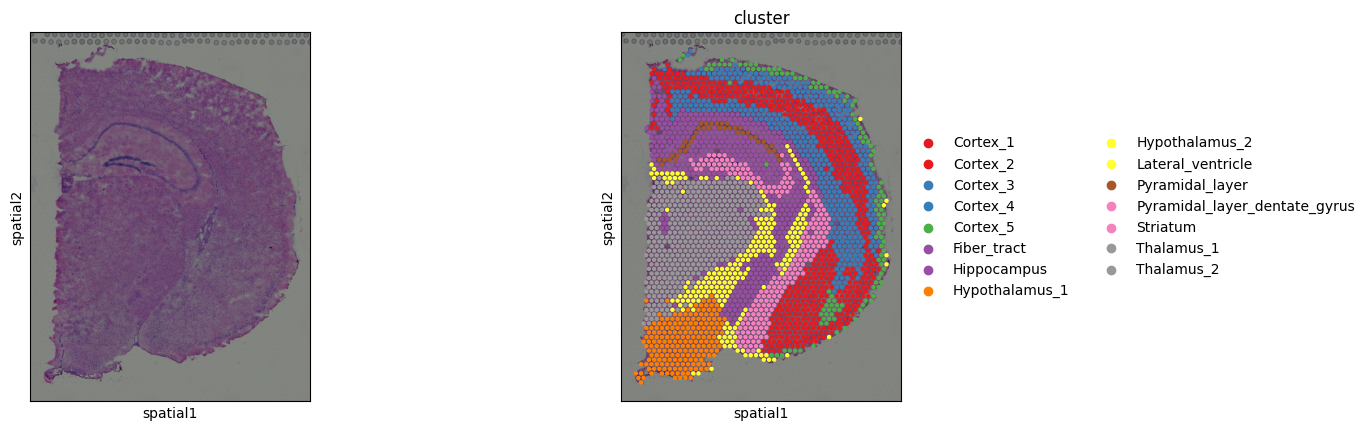

In [3]:
sc.pl.spatial(adata, color=[None, 'cluster'], size=1.3, palette='Set1')

In [4]:
li.ut.spatial_neighbors(adata, bandwidth=150, cutoff=0.1, kernel='gaussian', set_diag=True)

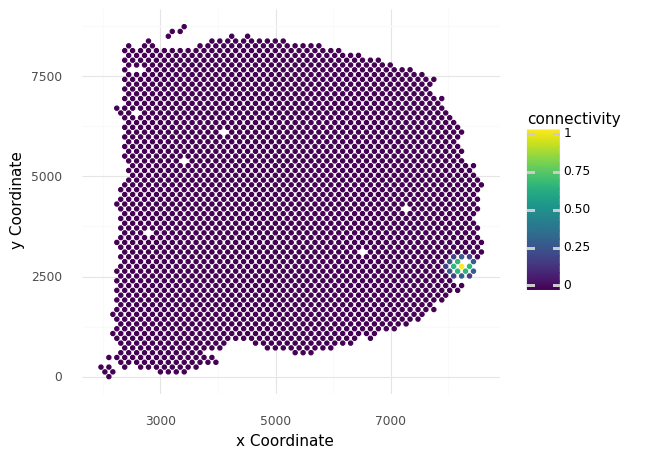

<ggplot: (8768380693598)>

In [5]:
li.pl.connectivity(adata, idx=0, size=1.3)

In [6]:
# Load metabolite receptor interactions
resource =  pd.read_csv('data/MR_brain_20230808.csv')
resource = dc.translate_net(resource, columns=['receptor'])
resource.head()

Unnamed: 0       ligand receptor
0           1  HMDB0000112   Gabrb2
1           3  HMDB0000216   Adra2b
2           4  HMDB0000068   Adra2b
3          20  HMDB0000148     Grm8
4          49  HMDB0000112   Gabra5

In [8]:
met_net = pd.read_csv("data/PD_processed.csv")

In [9]:
met_net = dc.translate_net(met_net, columns=['Symbol'])
met_net.head()

Unnamed: 0         HMDB Symbol  Direction                     MetName  \
0       18524  HMDB0059655  Phgdh          1          2-Hydroxyglutarate   
1       18527  HMDB0001487  Phgdh          1                        NADH   
2       18526  HMDB0001024  Phgdh          1  Phosphohydroxypyruvic acid   
3       18525  HMDB0000902  Phgdh          1                         NAD   
4       18522  HMDB0000208  Phgdh         -1            Oxoglutaric acid   

  Transport T_direction Reversibility                          DB     Type  
0   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
1   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
2   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
3   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
4   unknown     unknown  irreversible  ReconProductionDegradation  met_est

In [14]:
# estimate metabolites
mdata = estimate_metalinks(adata, resource=resource, met_net=met_net, consider_transport=True, min_n=3)

In [15]:
mdata.mod['metabolite'].X[mdata.mod['metabolite'].X <= 0] = 0

In [40]:
li.mt.bivar(mdata,
            x_mod="metabolite",
            y_mod="rna",
            x_transform=li.ut.zi_minmax,
            y_transform=li.ut.zi_minmax,
            function_name="morans",
            resource=resource,
            mask_negatives=True,
            add_categories=True,
            y_name="receptor",
            x_name="ligand",
            xy_sep="<->",
            )

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


In [41]:
mdata.uns['global_res'].sort_values("global_r", ascending=False).head(20)

Unnamed: 0           interaction       ligand  ligand_means  \
8          2557  HMDB0000112<->Gabra2  HMDB0000112      0.320500   
5          1178  HMDB0000112<->Gabrb3  HMDB0000112      0.320500   
6          1335  HMDB0000112<->Gabrg2  HMDB0000112      0.320500   
7          1967  HMDB0000112<->Gabra1  HMDB0000112      0.320500   
12         3473  HMDB0000112<->Gabra3  HMDB0000112      0.320500   
96         1563  HMDB0000123<->Slc6a9  HMDB0000123      0.084912   
1            49  HMDB0000112<->Gabra5  HMDB0000112      0.320500   
61         3555    HMDB0000148<->Grm4  HMDB0000148      0.008653   
101        2606    HMDB0000077<->Esr1  HMDB0000077      0.070485   
47         1016    HMDB0000148<->Grm1  HMDB0000148      0.008653   
34          718    HMDB0000073<->Drd2  HMDB0000073      0.123221   
2           405  HMDB0000112<->Gabrg1  HMDB0000112      0.320500   
94          321   HMDB0000123<->Glra1  HMDB0000123      0.084912   
10         2869  HMDB0000112<->Gabbr2  HMDB0000112      0.320500   
78         2099   HMDB0000073<->Htr1b  HMDB0000073      0.123221   
109        1053      HMDB0000053<->Ar  HMDB0000053      0.311092   
3           820  HMDB0000112<->Gabrg3  HMDB0000112      0.320500   
91         2229    HMDB0001852<->Rxrb  HMDB0001852      0.269362   
92         2968    HMDB0001852<->Rorb  HMDB0001852      0.269362   
58         2931  HMDB0000148<->Grin2d  HMDB0000148      0.008653   

     ligand_props receptor  receptor_means  receptor_props  global_r  \
8        0.853423   Gabra2        0.424055        0.780134  0.177323   
5        0.853423   Gabrb3        0.393617        0.837426  0.168333   
6        0.853423   Gabrg2        0.525260        0.835565  0.166328   
7        0.853423   Gabra1        0.582197        0.936012  0.147307   
12       0.853423   Gabra3        0.264072        0.574777  0.145832   
96       0.517485   Slc6a9        0.248691        0.603051  0.127556   
1        0.853423   Gabra5        0.279684        0.511905  0.124733   
61       0.069940     Grm4        0.132147        0.273065  0.067507   
101      0.757068     Esr1        0.039022        0.081473  0.060646   
47       0.069940     Grm1        0.268173        0.531250  0.047859   
34       0.485119     Drd2        0.045353        0.097842  0.039561   
2        0.853423   Gabrg1        0.174403        0.384673  0.039344   
94       0.517485    Glra1        0.013910        0.024926  0.037669   
10       0.853423   Gabbr2        0.543393        0.911086  0.035159   
78       0.485119    Htr1b        0.070567        0.172991  0.032154   
109      0.928199       Ar        0.154512        0.364211  0.025717   
3        0.853423   Gabrg3        0.122838        0.324033  0.023443   
91       0.682664     Rxrb        0.297414        0.632812  0.021926   
92       0.682664     Rorb        0.223216        0.532738  0.021142   
58       0.069940   Grin2d        0.141230        0.303571  0.019745   

    global_pvals  
8           None  
5           None  
6           None  
7           None  
12          None  
96          None  
1           None  
61          None  
101         None  
47          None  
34          None  
2           None  
94          None  
10          None  
78          None  
109         None  
3           None  
91          None  
92          None  
58          None

In [42]:
interaction = 'HMDB0000112<->Gabra2'

In [43]:
lrdata = mdata.mod['local_scores']

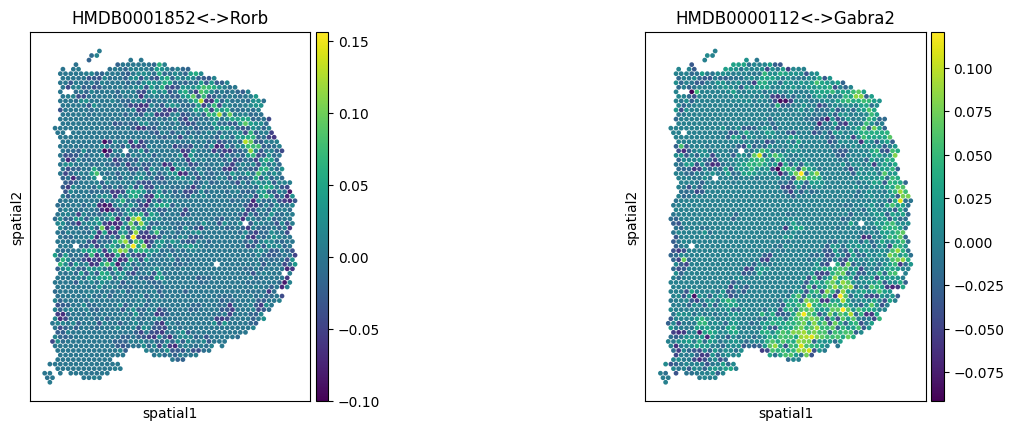

In [44]:
# print retinoic acid interaction and other alternatives
sq.pl.spatial_scatter(lrdata, color=['HMDB0001852<->Rorb', interaction], size=1.4, img=False)

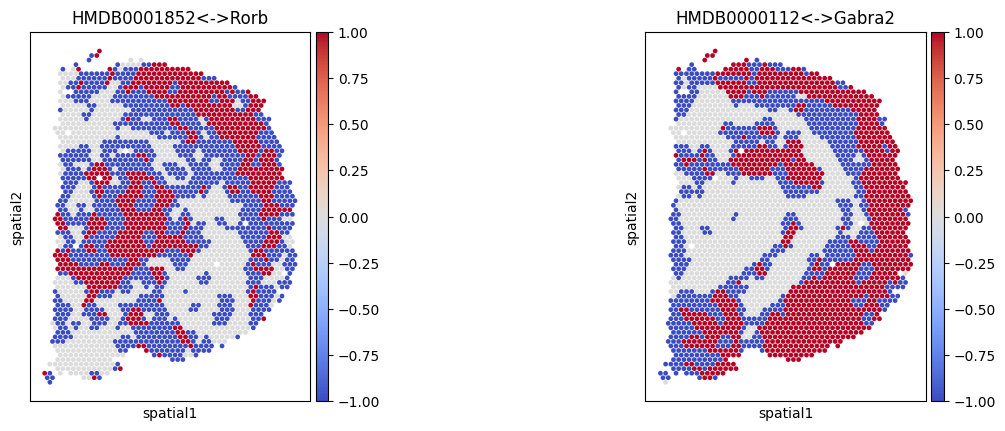

In [45]:
sq.pl.spatial_scatter(lrdata, color=['HMDB0001852<->Rorb', interaction], size=1.4, img=False, cmap='coolwarm', layer='cats')

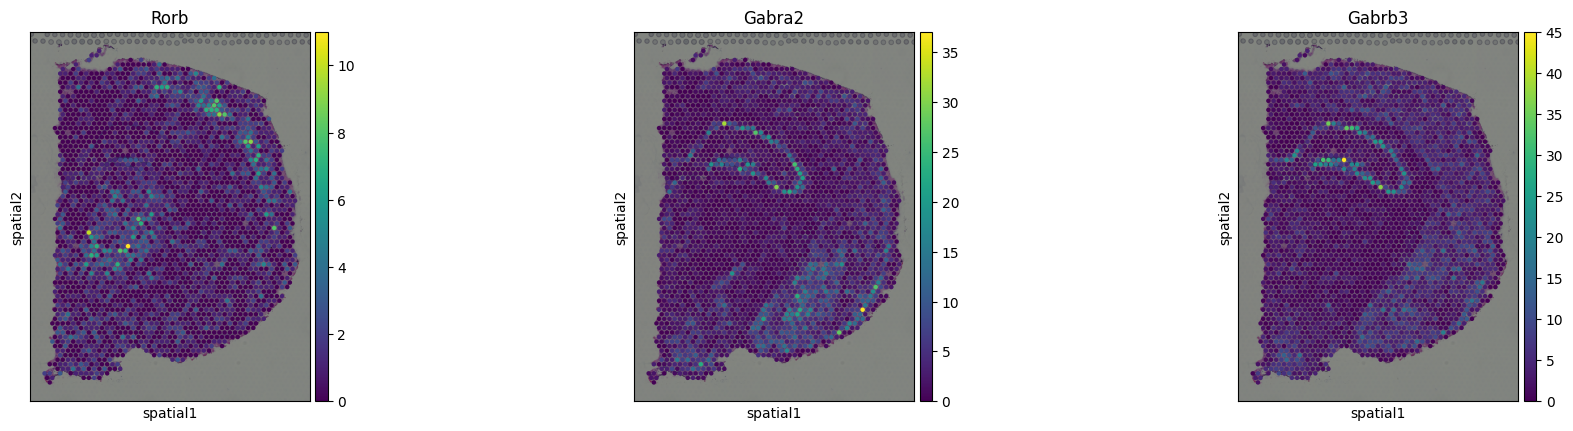

In [46]:
sc.pl.spatial(mdata.mod['rna'], color=['Rorb', 'Gabra2', 'Gabrb3'], size=1.3, palette='Paired')

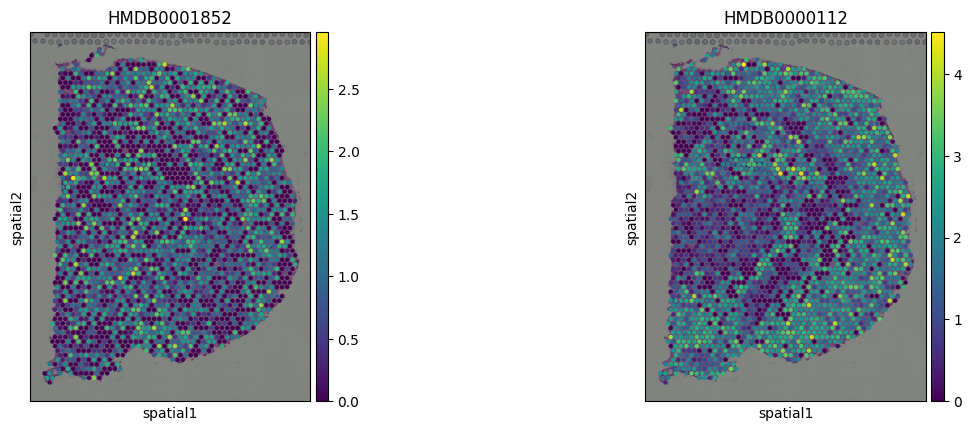

In [24]:
# display expression of retinoic acid HMDB0001852 and potential alternative GABA HMDB0000112
sc.pl.spatial(mdata.mod['metabolite'], color=[ 'HMDB0001852', 'HMDB0000112'], size=1.3, palette='Set1')

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


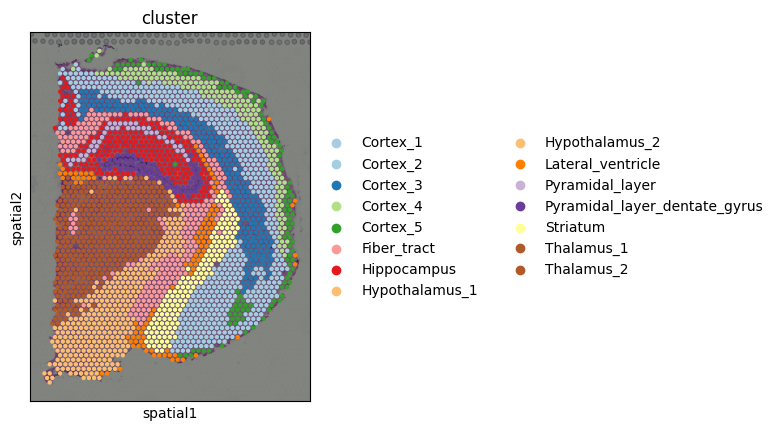

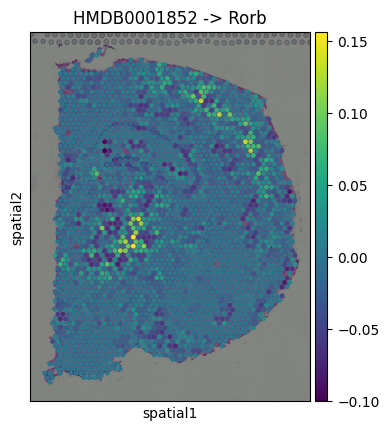

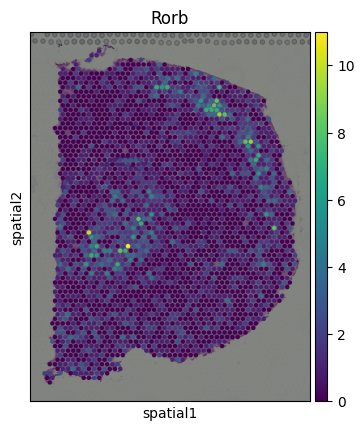

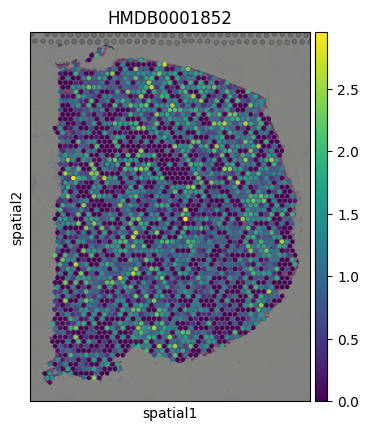

In [25]:
#plot them all separately
sc.pl.spatial(mdata.mod['rna'], color=['cluster'], size=1.3, palette='Paired')
sc.pl.spatial(lrdata, color= 'HMDB0001852<->Rorb',  size=1.4, title='HMDB0001852 -> Rorb')
sc.pl.spatial(mdata.mod['rna'], color='Rorb', size=1.3)
sc.pl.spatial(mdata.mod['metabolite'], color='HMDB0001852', size=1.3, palette='Set1')

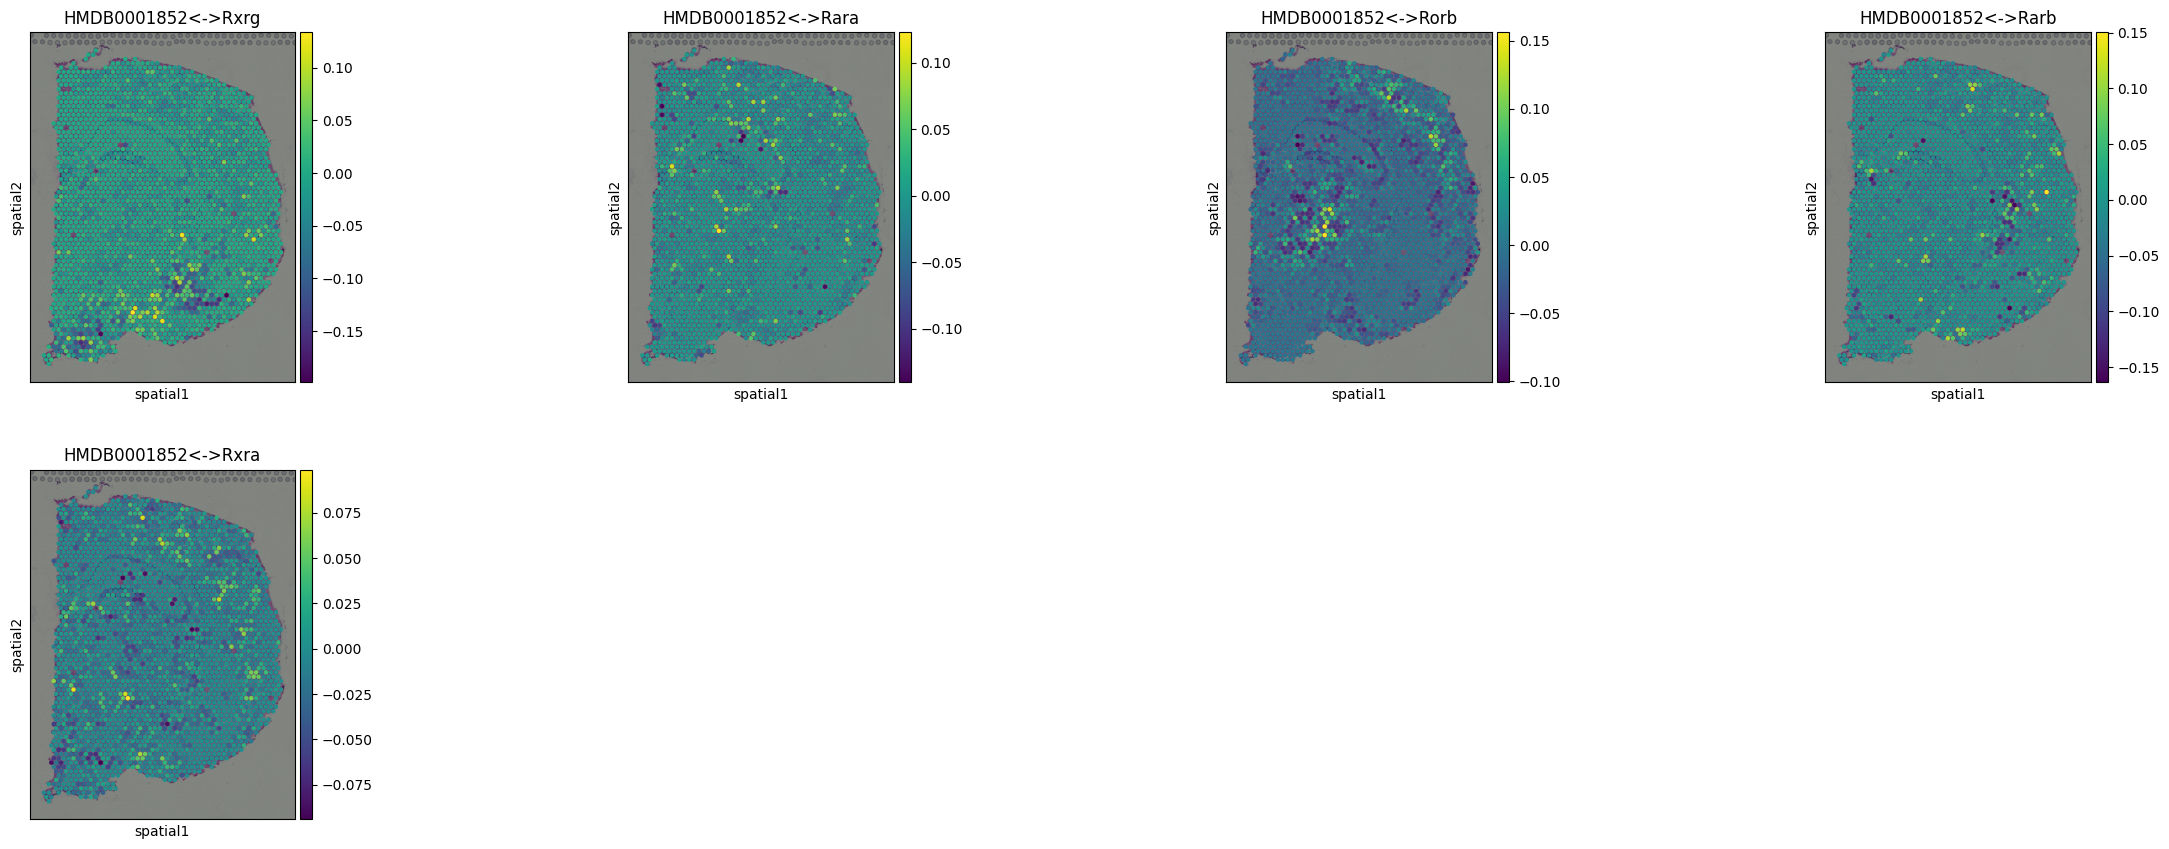

In [26]:
# print other retinoic acid interactions
sc.pl.spatial(lrdata, color=['HMDB0001852<->Rxrg', 'HMDB0001852<->Rara', 'HMDB0001852<->Rorb', 'HMDB0001852<->Rarb', 'HMDB0001852<->Rxra'], size=1.4)

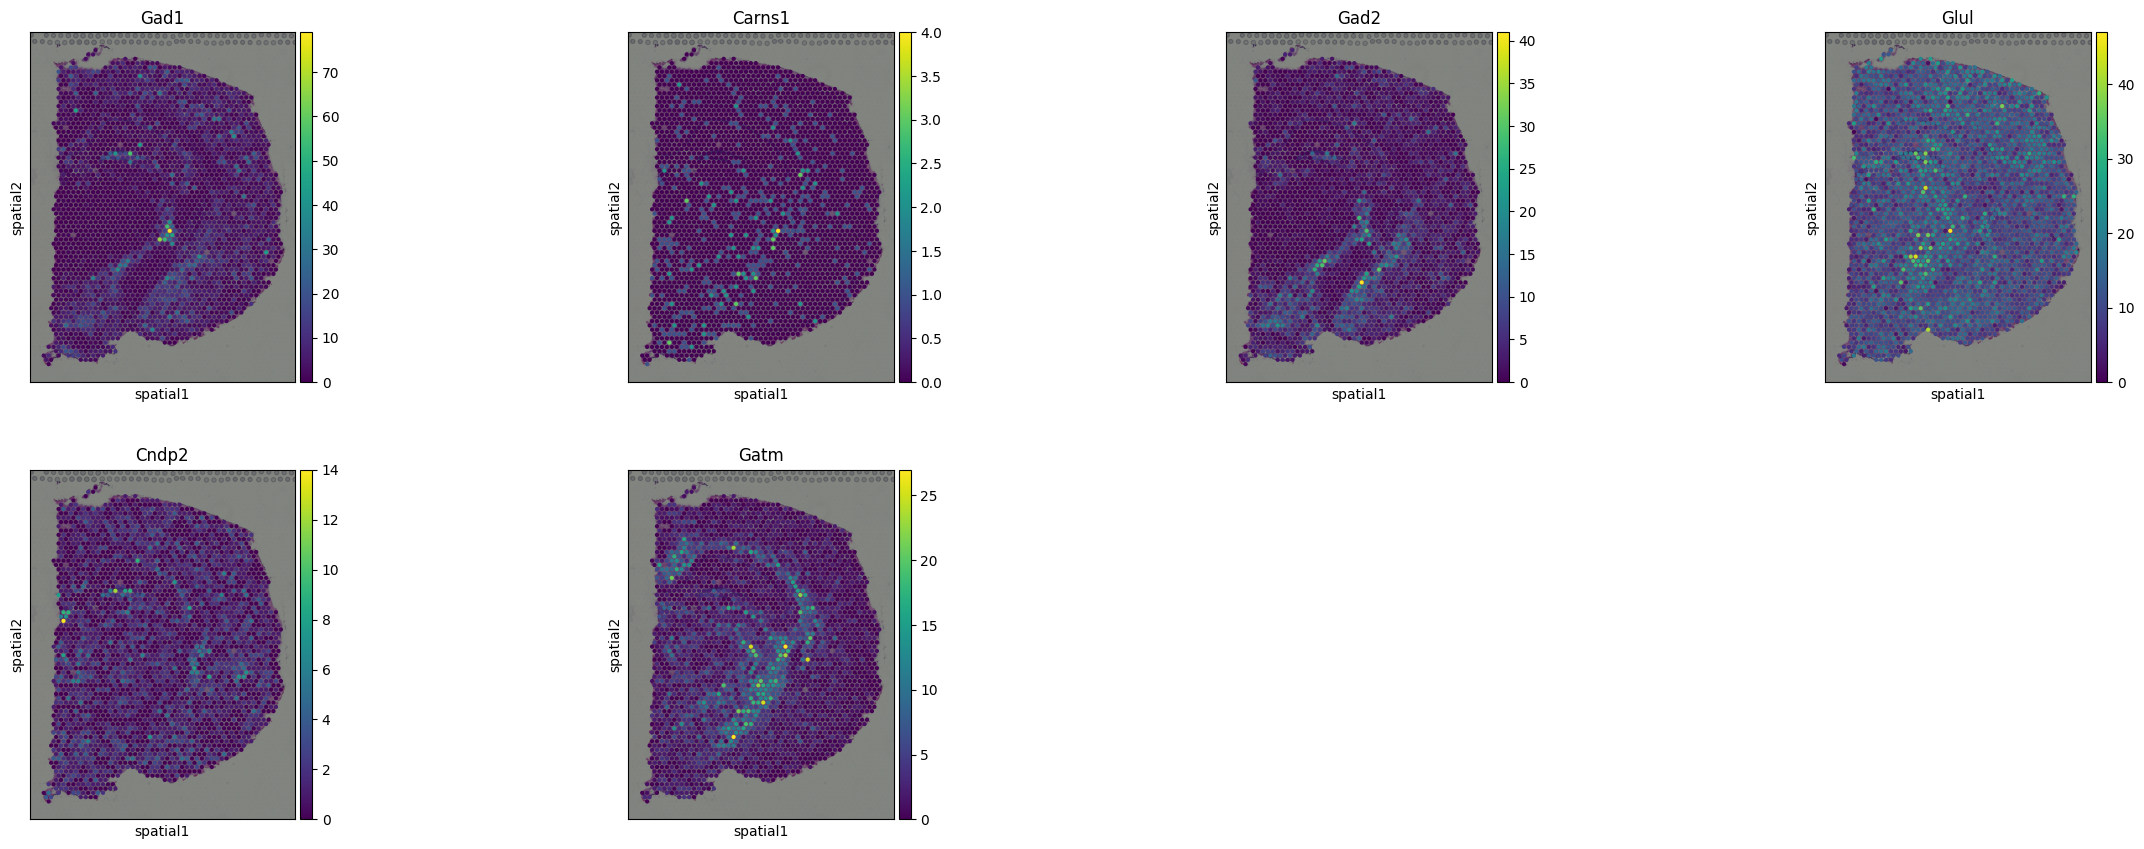

In [33]:
# plot all the genes that play a role in retinoic acid set
met_sets = met_net[met_net['Type']=='met_est']
genes = met_sets[met_sets['HMDB'] == 'HMDB0000112']['Symbol']
#remove Cyp4a11
#lower case except first letter
genes = [gene[0].upper() + gene[1:].lower() for gene in genes]
# remove genes that are not in adata.var.index
genes = [gene for gene in genes if gene in adata.var.index]
sc.pl.spatial(adata, color=genes, size=1.3, palette='Paired')